### Imports
Importing all the required libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model

In [2]:
import numpy as np
import itertools
import os
import shutil
import glob
import random
import matplotlib.pyplot as plt
import warnings
%matplotlib inline

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Creating train, valid and test batches

In [4]:
train_path = 'train/'
valid_path = 'valid/'
test_path = 'test/'

In [5]:
class_labels = [
            "ALEXANDRINE PARAKEET",
            "ANNAS HUMMINGBIRD",
            "ANTBIRD",
            "BALD EAGLE",
            "BARN OWL",
            "BARN SWALLOW",
            "BELTED KINGFISHER",
            "BLACK SWAN",
            "BLACK VULTURE",
            "BLACK-THROATED SPARROW",
            "CHIPPING SPARROW",
            "CROW",
            "CROWNED PIGEON",
            "DOWNY WOODPECKER",
            "EMPEROR PENGUIN",
            "EMU",
            "FLAMINGO",
            "GILA WOODPECKER",
            "HORNBILL",
            "HOUSE SPARROW",
            "JAVA SPARROW",
            "KING VULTURE",
            "KIWI",
            "LONG-EARED OWL",
            "MALABAR HORNBILL",
            "MALACHITE KINGFISHER",
            "MALLARD DUCK",
            "MANDRIN DUCK",
            "MYNA",
            "NICOBAR PIGEON",
            "OSTRICH",
            "PEACOCK",
            "PELICAN",
            "ROCK DOVE",
            "RUFOUS KINGFISHER",
            "SNOWY OWL",
            "STORK BILLED KINGFISHER",
            "TREE SWALLOW",
            "TRUMPTER SWAN",
            "WOOD DUCK"
]

len(class_labels)

40

In [6]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224, 224), classes= class_labels, batch_size=40)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224, 224), classes= class_labels, batch_size=16)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224, 224), classes= class_labels, batch_size=16)

Found 14095 images belonging to 40 classes.
Found 1677 images belonging to 40 classes.
Found 1679 images belonging to 40 classes.


### Data Exploration

In [7]:
imgs, labels = next(train_batches)

In [8]:
def plotImages(image_arr, batch_size):
    fig, axes = plt.subplots(1, batch_size, figsize = (20,20))
    axes = axes.flatten()
    for img, ax in zip(image_arr, axes):
        ax.imshow((img).astype(np.uint8))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

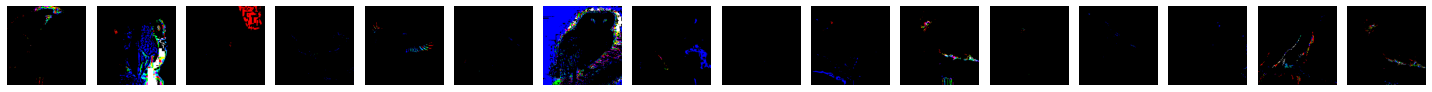

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [9]:
plotImages(imgs, 16)
print(labels)

### Creating and training model

In [10]:
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [11]:
x = mobile.layers[-6].output

In [12]:
output = Dense(units=40, activation='softmax')(x)

In [13]:
model = Model(inputs=mobile.input, outputs=output)

In [14]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [15]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

In [17]:
model.compile(optimizer=Adam
              (learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
class stopTrainingCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') > 0.965):   
            print("\nReached more than 96.5% accuracy, so stopping training")   
            self.model.stop_training = True
        
callbacks = stopTrainingCallback()

In [20]:
history = model.fit(x=train_batches,
         steps_per_epoch=len(train_batches),
         validation_data=valid_batches,
         validation_steps=len(valid_batches),
         epochs=7,
         verbose=1,
         callbacks=[callbacks]
        )

Epoch 1/7
353/353 [==============================] - 1167s 3s/step - loss: 2.9647 - accuracy: 0.2917 - val_loss: 1.8761 - val_accuracy: 0.5820
Epoch 2/7
353/353 [==============================] - 816s 2s/step - loss: 1.2528 - accuracy: 0.7891 - val_loss: 0.9379 - val_accuracy: 0.8527
Epoch 3/7
353/353 [==============================] - 632s 2s/step - loss: 0.6668 - accuracy: 0.9144 - val_loss: 0.5997 - val_accuracy: 0.9135
Epoch 4/7
353/353 [==============================] - 622s 2s/step - loss: 0.4238 - accuracy: 0.9498 - val_loss: 0.4391 - val_accuracy: 0.9302
Epoch 5/7
353/353 [==============================] - ETA: 0s - loss: 0.2961 - accuracy: 0.9680
Reached more than 96.5% accuracy, so stopping training
353/353 [==============================] - 625s 2s/step - loss: 0.2961 - accuracy: 0.9680 - val_loss: 0.3473 - val_accuracy: 0.9416


In [21]:
model.save("birdnetV83_MobileNet")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: birdnetV83_MobileNet\assets


### Predictions and results

In [22]:
history.history

{'loss': [2.964668035507202,
  1.2528280019760132,
  0.6668410301208496,
  0.4238252639770508,
  0.296050488948822],
 'accuracy': [0.2917346656322479,
  0.7890741229057312,
  0.9144377708435059,
  0.9498403668403625,
  0.9680028557777405],
 'val_loss': [1.8760638236999512,
  0.9379424452781677,
  0.5997380614280701,
  0.4391285479068756,
  0.3472573161125183],
 'val_accuracy': [0.5819916725158691,
  0.8527131676673889,
  0.9135360717773438,
  0.930232584476471,
  0.941562294960022]}

In [23]:
model.evaluate(x=test_batches,
              verbose=1)

105/105 [==============================] - 36s 342ms/step - loss: 0.3665 - accuracy: 0.9363


[0.36649975180625916, 0.936271607875824]